In [20]:
#Files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

#CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

#VIS
from keras.utils.vis_utils import plot_model

In [2]:
def _prepareData(path): 
    '''
    parameters: path(STR) of the directory and flag(INT) to know if we prepare data of training or testing
    return: (LIST) of images of the dataset and the (LIST) of labels
    
    For training:
    -Read images of every directory and extract all images
    -Resize to (128,128,3)
    -Read the directory name and asign as a class
    '''
    imgsList = []
    labels = []
    for directory in sorted(glob.glob(os.path.join(path, '*')), key = lambda k: k.split("/")[-1]):
            for imgs in glob.glob(os.path.join(directory,'*.jpg')):
                img_cv = cv2.imread(imgs)
                img_cv_r = cv2.resize(img_cv,(128,128))
                imgsList.append(img_cv_r)
                labels.append(int(directory.split("/")[-1].replace('c','')))
    

    X_Train, X_Test, Y_Train, Y_Test =  train_test_split(imgsList,labels, test_size = 0.2)
    Y_Train = tf.keras.utils.to_categorical(Y_Train, num_classes=10)
    Y_Test = tf.keras.utils.to_categorical(Y_Test, num_classes=10)

    return np.array(X_Train), np.array(X_Test), Y_Train, Y_Test

In [3]:
#Paths
pathTrain_Images = "/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/imgs/train"
pathPropagate_Images =  "/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/imgs/test"

#List of Images for Train and Test
X_Train, X_Test, Y_Train, Y_Test = _prepareData(pathTrain_Images)

print("Size X_Train: {}, Size Y_Train: {}".format(len(X_Train),len(Y_Train)))
print("Size X_Test: {}, Size Y_Test: {}".format(len(X_Test),len(Y_Test)))

Size X_Train: 17939, Size Y_Train: 17939
Size X_Test: 4485, Size Y_Test: 4485


## Check Data Intergrity

### Classes: 
c0: safe driving <br> c1: texting - right <br>c2: talking on the phone - right <br> c3: texting - left <br> c4: talking on the phone - left <br> c5: operating the radio <br>c6: drinking <br> c7: reaching behind <br>c8: hair and makeup <br>c9: talking to passenger

17939
(128, 128, 3)


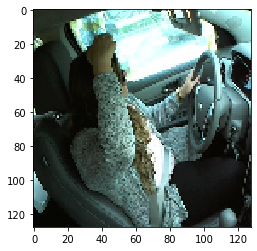

Class: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [4]:
print(len(X_Train))
print(X_Train[202].shape)
im = X_Train[202]
RGB_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_im)
plt.show()
print("Class: {}".format(Y_Train[202]))

## Check Data Distribution

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

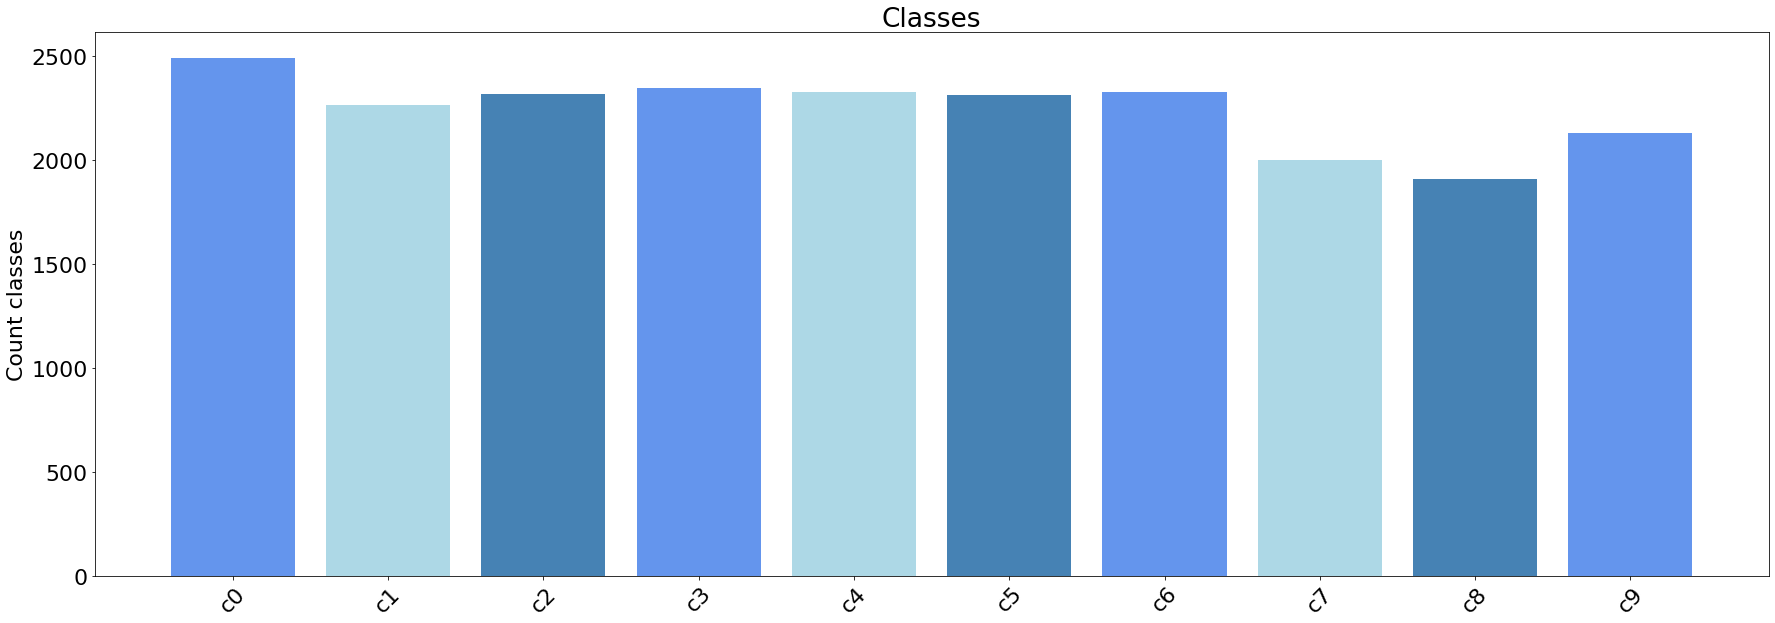

In [5]:
data_file = pd.read_csv("/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/driver_imgs_list.csv")
data_classes = data_file.loc[:,['classname','img']].groupby(by='classname').count().reset_index()

data_x = list(pd.unique(data_file['classname']))
data_y =list(data_classes['img'])

# Parámetros de ploteo (Se va a generar un plot diferente para cada Clase)
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,10))
plt.bar(data_x, data_y, color=['cornflowerblue', 'lightblue', 'steelblue'])  
plt.ylabel('Count classes')
plt.title('Classes')
plt.xticks(rotation=45)

## Create Architecture

In [6]:
model = keras.models.Sequential()

# 64 conv2d filters with relu
model.add(keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(128,128,3), kernel_initializer='glorot_normal'))
model.add(keras.layers.MaxPooling2D(pool_size=2)) #Maxpool
model.add(keras.layers.Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(keras.layers.MaxPooling2D(pool_size=2)) #Maxpool
model.add(keras.layers.Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(keras.layers.MaxPooling2D(pool_size=2)) #Maxpool
model.add(keras.layers.Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(keras.layers.MaxPooling2D(pool_size=2)) #Maxpool
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_normal'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       131328    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 512)       5

In [7]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## Train Model

In [8]:
history = model.fit(x = X_Train, y=Y_Train,epochs = 10, batch_size = 500, verbose = 1,validation_split=0.2)

Train on 14351 samples, validate on 3588 samples
Epoch 1/10
14351/14351 [==============================] - 617s 43ms/sample - loss: 40.8615 - accuracy: 0.1993 - val_loss: 1.8158 - val_accuracy: 0.3838
Epoch 2/10
14351/14351 [==============================] - 640s 45ms/sample - loss: 1.6456 - accuracy: 0.4537 - val_loss: 1.4157 - val_accuracy: 0.4891
Epoch 3/10
14351/14351 [==============================] - 2233s 156ms/sample - loss: 1.0199 - accuracy: 0.6767 - val_loss: 1.7030 - val_accuracy: 0.5240
Epoch 4/10
14351/14351 [==============================] - 697s 49ms/sample - loss: 1.5062 - accuracy: 0.6505 - val_loss: 0.6930 - val_accuracy: 0.7430
Epoch 5/10
14351/14351 [==============================] - 998s 70ms/sample - loss: 0.5846 - accuracy: 0.8227 - val_loss: 0.3527 - val_accuracy: 0.8885
Epoch 6/10
14351/14351 [==============================] - 865s 60ms/sample - loss: 1.3129 - accuracy: 0.7804 - val_loss: 0.1170 - val_accuracy: 0.9652
Epoch 7/10
14351/14351 [==================

## Evaluate Model with Test Data

In [9]:
test_loss, test_acc = model.evaluate(X_Test, Y_Test, verbose = 1)

4485/4485 [==============================] - 38s 9ms/sample - loss: 0.0550 - accuracy: 0.9844


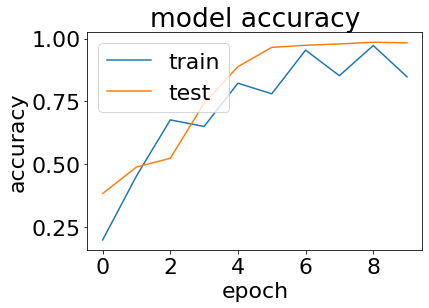

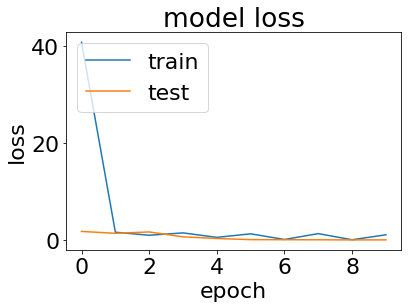

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.ylim([0.9,1])
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.ylim([0,.4])
plt.legend(['train','test'], loc='upper left')
plt.show()

### Save Weights

In [11]:
model_json = model.to_json()
model.save_weights('Train_weights_1.h5',overwrite = True)

In [12]:
model.load_weights('Train_weights_1.h5')

## Show Architecture Distribution

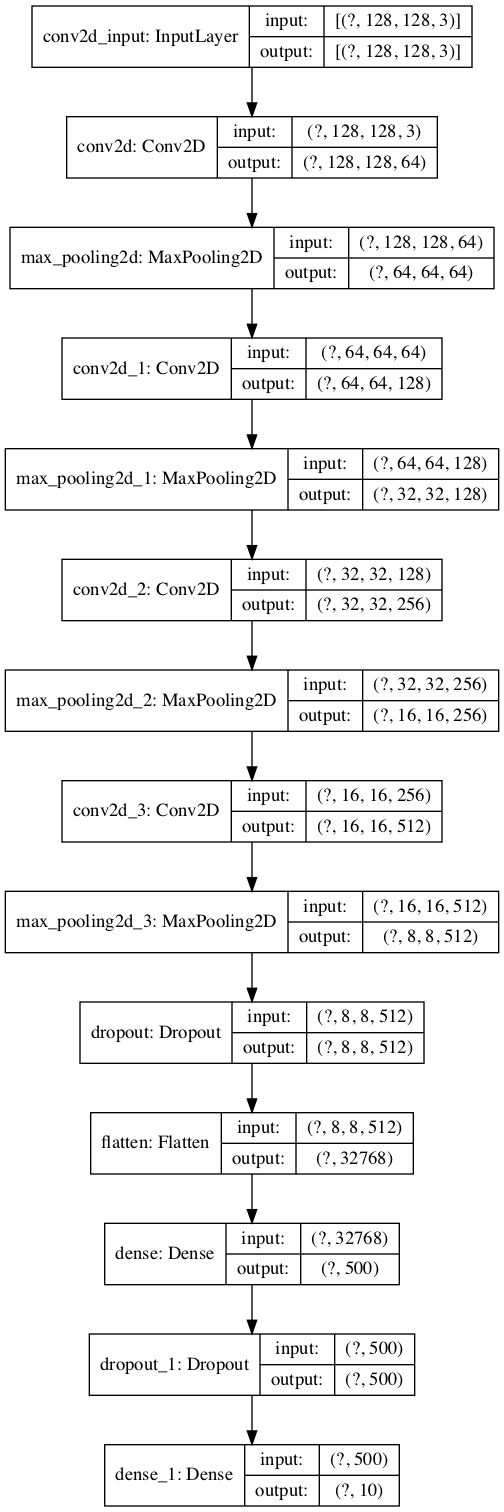

In [13]:
keras.utils.plot_model(model,"model.png",show_shapes = True)

## Model 1

## Predict Test Data and Create Submission File

In [14]:
df = pd.DataFrame({'img':[],'c0':[], 'c1':[],'c2':[], 'c3':[], 'c4':[],'c5':[], 'c6':[], 'c7':[], 'c8':[], 'c9':[]})
def _submission(pathPropagate_Images,df):
    for imgs in glob.glob(os.path.join(pathPropagate_Images,'*.jpg')):
        img_cv = cv2.imread(imgs)
        img_cv_r = cv2.resize(img_cv,(128,128))
        img_cv_predict = np.reshape(img_cv_r,[1,128,128,3])
        arr_predict = model.predict(img_cv_predict,batch_size = 1)
        #print(imgs.split('/')[-1])
        df = df.append(
            {
                'img':imgs.split('/')[-1],
                'c0':round(arr_predict[0][0],2), 
                'c1':round(arr_predict[0][1],2),
                'c2':round(arr_predict[0][2],2),
                'c3':round(arr_predict[0][3],2),
                'c4':round(arr_predict[0][4],2),
                'c5':round(arr_predict[0][5],2),
                'c6':round(arr_predict[0][6],2),
                'c7':round(arr_predict[0][7],2),
                'c8':round(arr_predict[0][8],2),
                'c9':round(arr_predict[0][9],2)
            },
            ignore_index=True
        )
    return df

In [22]:
img_cv = cv2.imread("/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/imgs/test/img_41.jpg")
img_cv_r = cv2.resize(img_cv,(128,128))
img_cv_predict = np.reshape(img_cv_r,[1,128,128,3])
arr_predict = model.predict(img_cv_predict,batch_size = 1)

print(arr_predict)
print(round(arr_predict[0][9],2))


[[1.4189318e-01 6.6052862e-02 1.5566849e-02 1.5990266e-01 6.9795740e-03
  5.3947391e-03 1.7422667e-02 2.7137576e-04 5.1813549e-03 5.8133477e-01]]
0.58


In [21]:
bb1_cv = cv2.imread("/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/imgs/bb1.jpg")
img_cv_r = cv2.resize(bb1_cv,(128,128))
img_cv_predict = np.reshape(img_cv_r,[1,128,128,3])
arr_predict = model.predict(img_cv_predict,batch_size = 1)

print(arr_predict)
print(round(arr_predict[0][9],2))


error: OpenCV(4.4.0) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-4jcifzim/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
bb1_cv = cv2.imread("/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/imgs/bb1.jpg")
img_cv_r = cv2.resize(bb1_cv,(128,128))
img_cv_predict = np.reshape(img_cv_r,[1,128,128,3])
arr_predict = model.predict(img_cv_predict,batch_size = 1)

print(arr_predict)
print(round(arr_predict[0][9],2))


In [ ]:
bb1_cv = cv2.imread("/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/imgs/bb1.jpg")
img_cv_r = cv2.resize(bb1_cv,(128,128))
img_cv_predict = np.reshape(img_cv_r,[1,128,128,3])
arr_predict = model.predict(img_cv_predict,batch_size = 1)

print(arr_predict)
print(round(arr_predict[0][9],2))


In [16]:
pathPropagate_Images = "/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/imgs/test"
df = _submission(pathPropagate_Images,df)

In [17]:
print(df.shape)
df.head(50)

(79726, 11)


,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_60161.jpg,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
1,img_94786.jpg,0.00,0.01,0.00,0.00,0.00,0.33,0.58,0.00,0.05,0.03
2,img_85853.jpg,0.02,0.48,0.01,0.03,0.01,0.00,0.06,0.01,0.28,0.10
3,img_36327.jpg,0.11,0.16,0.00,0.04,0.00,0.00,0.31,0.00,0.00,0.37
4,img_39014.jpg,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
5,img_84595.jpg,0.01,0.00,0.00,0.36,0.62,0.00,0.00,0.00,0.00,0.01
6,img_57915.jpg,0.44,0.02,0.00,0.33,0.06,0.00,0.00,0.00,0.01,0.14
7,img_37039.jpg,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
8,img_11940.jpg,0.03,0.05,0.24,0.02,0.00,0.00,0.02,0.39,0.00,0.24
9,img_20545.jpg,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.38,0.56,0.01


In [18]:
df.to_csv('submission_file.csv',index = False)